In [1]:
#This is a solution to Task 3 where in we are supposed to implement circuits consisting of (H,I,X,Y,Z,Rx,Ry,Rz,CNot,Cz) 
# using only these three gates Rx,Rz,Cz . This ipynb file illustartes how this compiling can be done

from qiskit import QuantumCircuit,Aer,execute                                    #the packages used here are mostly from qiskit and qiskit_textbook
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex
from math import pi
import time

In [2]:
#Now let us first create a quantum circuit using as many gates as posiible(H,I,X,Y,Z,Ry,CNot) 
start = time.perf_counter()
qc = QuantumCircuit(4)

for i in range(4):
    qc.h(i)
    qc.x(i)
    if i%2 == 0:
        qc.y(i)
        qc.i(i)
        qc.ry(pi/4,i)
        
        
    else:
        qc.x(i)
        qc.z(i)
    qc.h(i)
qc.cnot(0,1)
end = time.perf_counter()

#This is a just random circuit that I created to illustrate my solution

qc.draw()  #draw the circuit


┌───┐┌───┐┌───┐┌───┐┌──────────┐┌───┐     
q_0: ┤ H ├┤ X ├┤ Y ├┤ I ├┤ RY(pi/4) ├┤ H ├──■──
     ├───┤├───┤├───┤├───┤└──┬───┬───┘└───┘┌─┴─┐
q_1: ┤ H ├┤ X ├┤ X ├┤ Z ├───┤ H ├─────────┤ X ├
     ├───┤├───┤├───┤├───┤┌──┴───┴───┐┌───┐└───┘
q_2: ┤ H ├┤ X ├┤ Y ├┤ I ├┤ RY(pi/4) ├┤ H ├─────
     ├───┤├───┤├───┤├───┤└──┬───┬───┘└───┘     
q_3: ┤ H ├┤ X ├┤ X ├┤ Z ├───┤ H ├──────────────
     └───┘└───┘└───┘└───┘   └───┘

In [3]:
print("time taken to implement: ")
print(end-start)

time taken to implement: 
0.001851695000000042


In [4]:
backend = Aer.get_backend('unitary_simulator')
unitary = execute(qc,backend).result().get_unitary()
# Display the unitary:
array_to_latex(unitary, pretext="\\text{Circuit = } ")

#lets have a look at how the unitary matrix of this circuit looks like

<IPython.core.display.Math object>

In [5]:
backend = Aer.get_backend('statevector_simulator')
final_state = execute(qc,backend).result().get_statevector()

# In Jupyter Notebooks we can display this nicely using Latex.
# If not using Jupyter Notebooks you may need to remove the 
# array_to_latex function and use print(final_state) instead.
from qiskit_textbook.tools import array_to_latex
array_to_latex(final_state, pretext="\\text{Statevector} = ")

#also let's see how it's state vector looks like after applying the gates

<IPython.core.display.Math object>

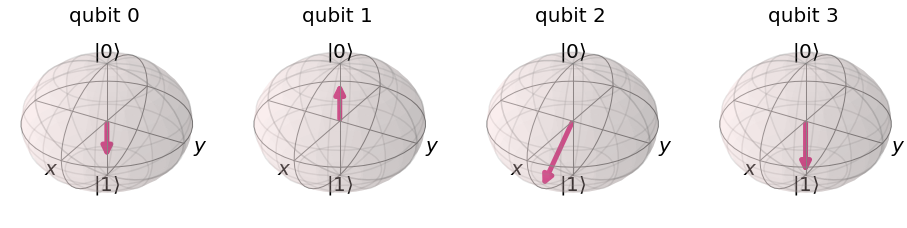

In [6]:
plot_bloch_multivector(final_state)
#And how could we forget the bloch spheres

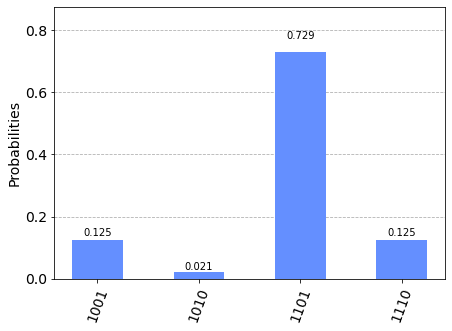

In [7]:
backend = Aer.get_backend('statevector_simulator')
final_counts = execute(qc,backend).result().get_counts()
plot_histogram(final_counts)

#finally the outcome which is run on a statevector simulator, so if we were to run the same on ibm computer the results may vary a little due to noise 

In [8]:
#now lets define all the gates used above in terms of only Rx,Rz,Cz Gates
#We will be using some identities to do it

def compile_h(qc,qubit):             #Identity used : H = Rz(pi/2)Rx(pi/2)Rz(pi/2)
    qc.rz(pi/2,qubit)
    qc.rx(pi/2,qubit)
    qc.rz(pi/2,qubit)
    
def compile_x(qc,qubit):             #Identity used : Rx(pi)=-iX (global phase difference exists)
    qc.rx(pi,qubit)

    
def compile_y(qc,qubit):              #Identity used : Y = SXSdg where S = Rz(pi/2) and Sdg = Rz(-pi/2)
    qc.rz(pi/2,qubit)
    compile_x(qc,qubit)
    qc.rz(-pi/2,qubit)
    
def compile_z(qc,qubit):              #Identity used : Rz(pi) = -Z (global phase difference exists)
    qc.rz(pi,qubit)
    
def compile_i(qc,qubit):              #Identity used : XX = I since X is its own inverse
    compile_x(qc, qubit)
    compile_x(qc, qubit)
    
def compile_ry(qc,theta,qubit):       #Identity used : Ry = SdgRx(-thetha)S 
    qc.rz(-pi/2,qubit)
    qc.rx(-theta,qubit)
    qc.rz(pi/2,qubit)
    
def compile_cnot(qc,c,t):             #Indentiy used: Cnot = HCzH where we simplify H in terms of Rx and Rz
    compile_h(qc,t)
    qc.cz(c,t)
    compile_h(qc,t)

    
    

In [9]:
#Now this is the most important step
#Here we override our user defined functions to compile on the actual funtion gates from qiskit
#So once we override whenever the user calls for an H gate using h() funtion then internally the compile_h() is called to break it down using only Rx,Rz gates
#Similarly for all other functions that we override with our user defined compile_<name> functions

import sys
 
module = sys.modules['qiskit']
module.QuantumCircuit.h = compile_h            #Overriding h() with compile_h()
module.QuantumCircuit.x = compile_x            #Overriding x() with compile_x()
module.QuantumCircuit.y = compile_y            #Overriding y() with compile_y()
module.QuantumCircuit.z = compile_z            #and so on for all the gates given here
module.QuantumCircuit.ry = compile_ry
module.QuantumCircuit.cnot = compile_cnot
module.QuantumCircuit.i = compile_i
sys.modules['qiskit'] = module

#Note: This function overriding is local to the session so it won't cause any changes to the original functions of QuantumCircuit.
#What I mean is if u end this session and run the program again without doin the overriding part then the program runs as it should run by default

In [11]:
#Now let us first create a quantum circuit using as many gates as posiible(H,I,X,Y,Z,Ry,CNot) 
start = time.perf_counter()
qc = QuantumCircuit(4)

for i in range(4):
    qc.h(i)
    qc.x(i)
    if i%2 == 0:
        qc.y(i)
        qc.i(i)
        qc.ry(pi/4,i)
        
        
    else:
        qc.x(i)
        qc.z(i)
    qc.h(i)
qc.cnot(0,1)
end = time.perf_counter()

#This is a just random circuit that I created to illustrate my solution

qc.draw()  #draw the circuit


┌──────────┐┌──────────┐┌──────────┐┌────────┐┌──────────┐┌────────┐»
q_0: ┤ RZ(pi/2) ├┤ RX(pi/2) ├┤ RZ(pi/2) ├┤ RX(pi) ├┤ RZ(pi/2) ├┤ RX(pi) ├»
     ├──────────┤├──────────┤├──────────┤├────────┤└┬────────┬┘├────────┤»
q_1: ┤ RZ(pi/2) ├┤ RX(pi/2) ├┤ RZ(pi/2) ├┤ RX(pi) ├─┤ RX(pi) ├─┤ RZ(pi) ├»
     ├──────────┤├──────────┤├──────────┤├────────┤┌┴────────┴┐├────────┤»
q_2: ┤ RZ(pi/2) ├┤ RX(pi/2) ├┤ RZ(pi/2) ├┤ RX(pi) ├┤ RZ(pi/2) ├┤ RX(pi) ├»
     ├──────────┤├──────────┤├──────────┤├────────┤└┬────────┬┘├────────┤»
q_3: ┤ RZ(pi/2) ├┤ RX(pi/2) ├┤ RZ(pi/2) ├┤ RX(pi) ├─┤ RX(pi) ├─┤ RZ(pi) ├»
     └──────────┘└──────────┘└──────────┘└────────┘ └────────┘ └────────┘»
«     ┌───────────┐ ┌────────┐  ┌────────┐ ┌───────────┐┌───────────┐»
«q_0: ┤ RZ(-pi/2) ├─┤ RX(pi) ├──┤ RX(pi) ├─┤ RZ(-pi/2) ├┤ RX(-pi/4) ├»
«     └┬──────────┤┌┴────────┴┐┌┴────────┴┐└┬──────────┤└┬──────────┤»
«q_1: ─┤ RZ(pi/2) ├┤ RX(pi/2) ├┤ RZ(pi/2) ├─┤ RZ(pi/2) ├─┤ RX(pi/2) ├»
«     ┌┴──────────┤└┬────────┬┘└┬────────┬┘┌┴──────────┤┌┴──────────┤»
«q_2: ┤ RZ(-pi/2) ├─┤ RX(pi) ├──┤ RX(pi) ├─┤ RZ(-pi/2) ├┤ RX(-pi/4) ├»
«     └┬──────────┤┌┴────────┴┐┌┴────────┴┐└───────────┘└───────────┘»
«q_3: ─┤ RZ(pi/2) ├┤ RX(pi/2) ├┤ RZ(pi/2) ├──────────────────────────»
«      └──────────┘└──────────┘└──────────┘                          »
«     ┌──────────┐┌──────────┐┌──────────┐┌──────────┐               »
«q_0: ┤ RZ(pi/2) ├┤ RZ(pi/2) ├┤ RX(pi/2) ├┤ RZ(pi/2) ├─■─────────────»
«     ├──────────┤└──────────┘└──────────┘└──────────┘ │ ┌──────────┐»
«q_1: ┤ RZ(pi/2) ├─────────────────────────────────────■─┤ RZ(pi/2) ├»
«     ├──────────┤┌──────────┐┌──────────┐┌──────────┐   └──────────┘»
«q_2: ┤ RZ(pi/2) ├┤ RZ(pi/2) ├┤ RX(pi/2) ├┤ RZ(pi/2) ├───────────────»
«     └──────────┘└──────────┘└──────────┘└──────────┘               »
«q_3: ───────────────────────────────────────────────────────────────»
«                                                                    »
«                             
«q_0: ────────────────────────
«     ┌──────────┐┌──────────┐
«q_1: ┤ RX(pi/2) ├┤ RZ(pi/2) ├
«     └──────────┘└──────────┘
«q_2: ────────────────────────
«                             
«q_3: ────────────────────────
«

In [12]:
print("time taken to implement: ")
print(end-start)

time taken to implement: 
0.003761952000019164


In [13]:
#And Voila, Our circuit is all interms of Rx,Rz,Cz
#But one task still remains that is to check if the behaviour of the circuit is same? i.e., to see if it yeilds the same result

backend = Aer.get_backend('unitary_simulator')
unitary = execute(qc,backend).result().get_unitary()
# Display the Unitary:
array_to_latex(unitary, pretext="\\text{Circuit = } ")

#lets have a look at its unitary (This may at some points appear different from original circuit but that's just because of glabal phase difference)

<IPython.core.display.Math object>

In [14]:
backend = Aer.get_backend('statevector_simulator')
final_state = execute(qc,backend).result().get_statevector()

# In Jupyter Notebooks we can display this nicely using Latex.
# If not using Jupyter Notebooks you may need to remove the 
# array_to_latex function and use print(final_state) instead.
from qiskit_textbook.tools import array_to_latex
array_to_latex(final_state, pretext="\\text{Statevector} = ")

#also let's have a look at the statevector

<IPython.core.display.Math object>

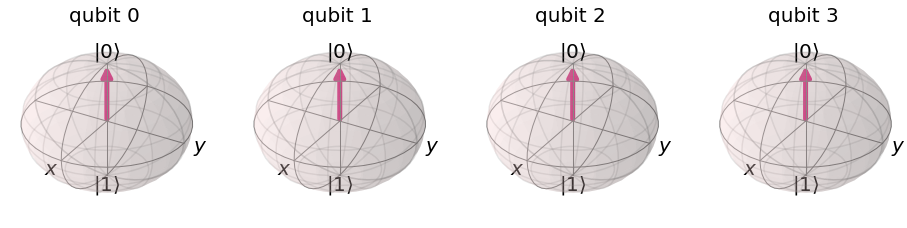

In [15]:

plot_bloch_multivector(final_state)

#And bloch spheres

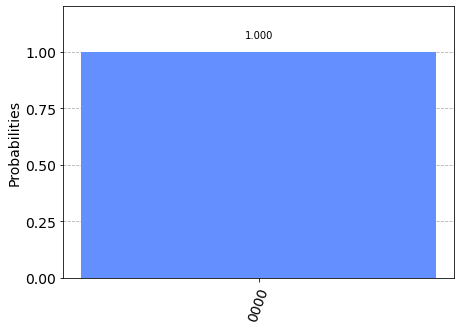

In [16]:
backend = Aer.get_backend('statevector_simulator')
final_counts = execute(qc,backend).result().get_counts()

plot_histogram(final_counts)

#This is the moment we have been waiting for, when u run it on a statevector simulator the results are same. This is true for any quantum circuit
#You can try for different quantum circuits yourself using this code and it should give the same results for all 
#as it preserves the Universality.
#The results on ibm quantum computer can get a little different from the original because of noise but the circuit still remains the same as the original

In [14]:
#The above program is kind of sequential which becomes hard to test for different circuits. 
#This program is to only explain the idea of how it works from step by step.
#I have also uploaded a small project named "Compiler Modular Approach" where i have done pretty much the same thing,
#but with one small change that is using a separate python file to do the overriding.
#So you can call function "compile_override()" whenever you need to over ride a circuit.


#Also I have uploaded a doc file to talk about the Overhead of the program and how we can implement it
